# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import time
tic = time.time()

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.convenience import (
    create_route, stochastic_search, gradient_descent, Logs, LogsRoute
)
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice
import xarray as xr
import shapely

## Parameters

In [4]:
population_size = 50

# reproducibility
random_seed = 345

# data sources
current_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# initial route
lon_waypoints = [-80.5, -10.0]
lat_waypoints = [30.0, 50.0]
time_start = "2021-08-13T12:00"
# time_end = "2021-08-21T12:00"
time_end = None
speed_knots = 8.0  # either one time and speed or both times needed
time_resolution_hours = 6.0

# stochastic search parameters
# stoch_number_of_iterations = 1
# stoch_acceptance_rate_target = 0.01

# gradient descent parameters
grad_num_iterations = 1
grad_learning_rate_percent_time = 0.5
grad_time_increment = 1_200
grad_learning_rate_percent_along = 0.5
grad_dist_shift_along = 15_000
grad_learning_rate_percent_across = 0.5
grad_dist_shift_across = 15_000

# experiment id
experiment_id = 2

In [5]:
np.random.seed(random_seed)

## Define a route

In [6]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=time_start,
    time_end=time_end,
    speed_knots=speed_knots,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-13T12:00:00')), WayPoint(lon=-79.82326985754581, lat=30.534808503062184, time=np.datetime64('2021-08-13T17:56:38.071')), WayPoint(lon=-79.139109120998, lat=31.0660194892236, time=np.datetime64('2021-08-13T23:53:16.142')), WayPoint(lon=-78.4473277659879, lat=31.593517668011053, time=np.datetime64('2021-08-14T05:49:54.214')), WayPoint(lon=-77.74773455145981, lat=32.11718478868122, time=np.datetime64('2021-08-14T11:46:32.285')), WayPoint(lon=-77.04013721563717, lat=32.636899568343146, time=np.datetime64('2021-08-14T17:43:10.357')), WayPoint(lon=-76.32434269596945, lat=33.15253762198593, time=np.datetime64('2021-08-14T23:39:48.428')), WayPoint(lon=-75.60015737467967, lat=33.6639713948614, time=np.datetime64('2021-08-15T05:36:26.499')), WayPoint(lon=-74.86738735157664, lat=34.17107009771546, time=np.datetime64('2021-08-15T11:33:04.571')), WayPoint(lon=-74.12583874583147, lat=34.67369964540788

In [7]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 4.115556756863966


## Load and plot currents, winds, waves

In [8]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [9]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 107. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 395. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 791. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)


<xarray.HashableDataset> Size: 41GB
Dimensions:  (time: 8760, lat: 440, lon: 880)
Coordinates:
  * lat      (lat) float32 2kB 10.06 10.19 10.31 10.44 ... 64.69 64.81 64.94
  * lon      (lon) float32 4kB -99.94 -99.81 -99.69 -99.56 ... 9.688 9.812 9.938
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    uw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    vw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    speed    (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>

In [10]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves

<xarray.HashableDataset> Size: 4GB
Dimensions:  (time: 2920, lat: 276, lon: 551)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... 9.4 9.6 9.8 10.0
  * time     (time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    wh       (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
    VMDR     (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>

## Subset for the route

In [11]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 704 ms, sys: 443 ms, total: 1.15 s
Wall time: 678 ms
CPU times: user 11.8 s, sys: 4.88 s, total: 16.7 s
Wall time: 2.26 s
CPU times: user 153 ms, sys: 38.2 ms, total: 191 ms
Wall time: 103 ms


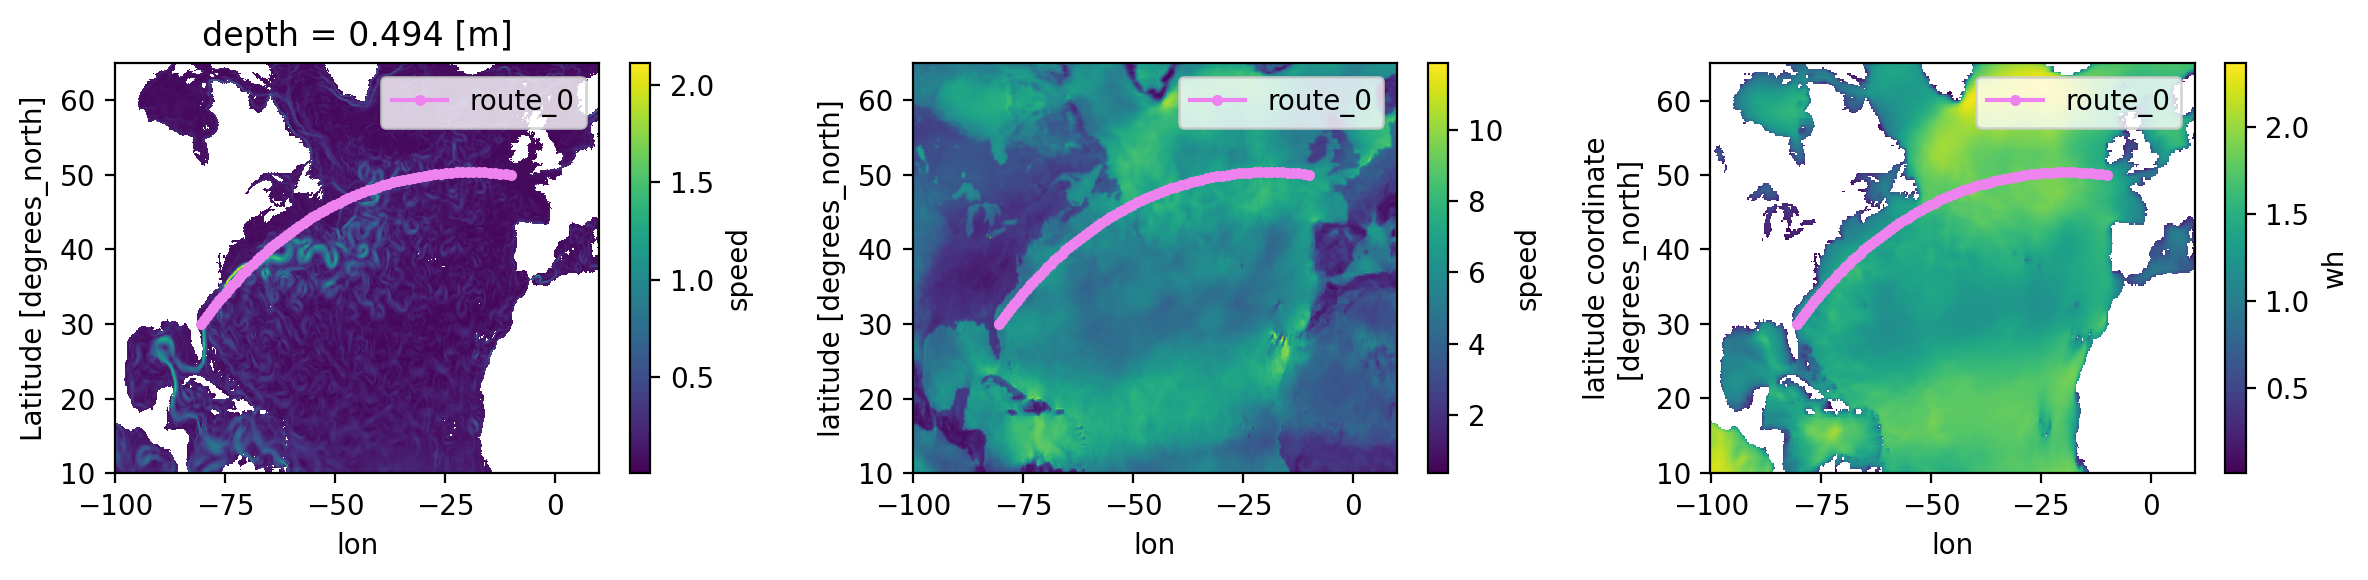

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Concurrency

In [13]:
from dask import delayed

In [14]:
@delayed
def stochastic_search_delayed(logs_routes, **kwargs):
    route = logs_routes.route
    mod_width = np.random.uniform(0, 1) * route.length_meters
    _route, _logs_routes = stochastic_search(
        route=route,
        mod_width=mod_width,
        max_move_meters=0.75 * mod_width,
        acceptance_rate_target=0,
        **kwargs,
    )
    return _logs_routes[-1]

In [15]:
_currents = currents.compute()
_winds = winds.compute()
_waves = waves.compute()

In [16]:
print(_currents.nbytes / 1e6)
print(_winds.nbytes / 1e6)
print(_waves.nbytes / 1e6)

178.136992
1937.557416
169.112932


In [17]:
from dask.distributed import Client

In [18]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit=10e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65083,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 37.25 GiB
Comm: tcp://127.0.0.1:65096,Total threads: 1
Dashboard: http://127.0.0.1:65101/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:65086,


In [19]:
currents = client.scatter(currents, broadcast=True)
winds = client.scatter(winds, broadcast=True)
waves = client.scatter(waves, broadcast=True)

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [20]:
population = [delayed(LogsRoute(logs=Logs(), route=route_0)) for _ in range(population_size)]

In [21]:
population = [
    stochastic_search_delayed(
        logs_routes=lr,
        number_of_iterations=1,
        acceptance_rate_for_increase_cost=0.5,
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for lr in population
]

In [22]:
@delayed
def select_cheaper(logs_routes_0, logs_routes_1, chance=0.2):
    if (
        (logs_routes_0.logs.cost < logs_routes_1.logs.cost)
        or (np.random.uniform(0, 1) < chance)
    ):
        return logs_routes_0
    else:
        return logs_routes_1

In [23]:
%%time

for n in range(5):
    population = [
        select_cheaper(population[n0], population[n1], chance=0.5)
        for n0, n1 in zip(
            range(len(population)),
            np.random.randint(0, len(population), size=(len(population), )),
        )
    ]
    population = [
        stochastic_search_delayed(
            logs_routes=lr,
            number_of_iterations=1,
            acceptance_rate_for_increase_cost=0.0,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        for lr in population
    ]
    population = [delayed(pc.compute()) for pc in [pp.persist() for pp in population]]

2024-12-19 16:58:58,375 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:65098 -> tcp://127.0.0.1:65105
Traceback (most recent call last):
  File "/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^

CPU times: user 7.94 s, sys: 1.33 s, total: 9.27 s
Wall time: 1min 41s


In [24]:
population = [pc.compute() for pc in [pp.persist() for pp in population]]

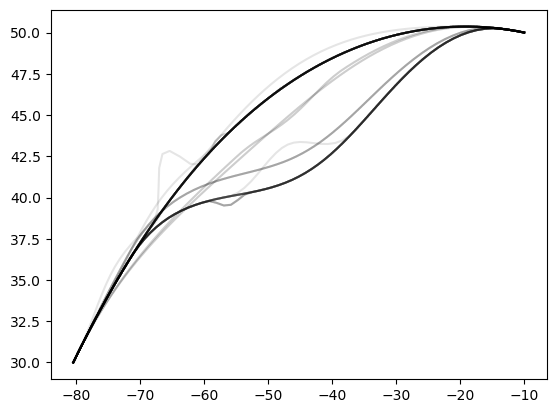

In [25]:
for lr in population:
    plt.plot(lr.route.data_frame.lon, lr.route.data_frame.lat, 'k-', alpha=0.1)

In [26]:
cost = [rl.logs.cost for rl in population]
lengths = [rl.route.length_meters for rl in population]

(array([13., 11.,  2.,  5., 18.,  0.,  0.,  0.,  0.,  1.]),
 array([2.77553562e+12, 2.81986078e+12, 2.86418594e+12, 2.90851110e+12,
        2.95283626e+12, 2.99716142e+12, 3.04148658e+12, 3.08581174e+12,
        3.13013690e+12, 3.17446206e+12, 3.21878722e+12]),
 <BarContainer object of 10 artists>)

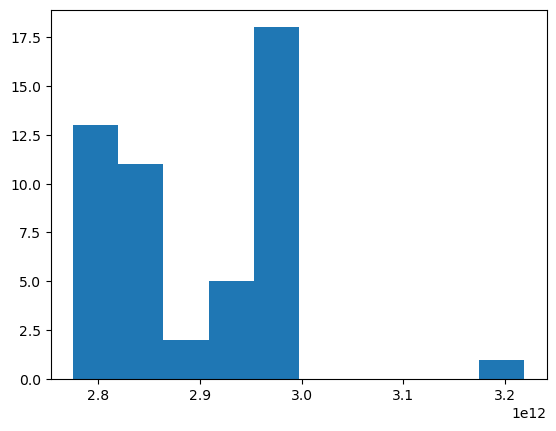

In [27]:
plt.hist(cost)

In [28]:
imin = np.argmin(cost)
imin

np.int64(25)

<Axes: xlabel='lon'>

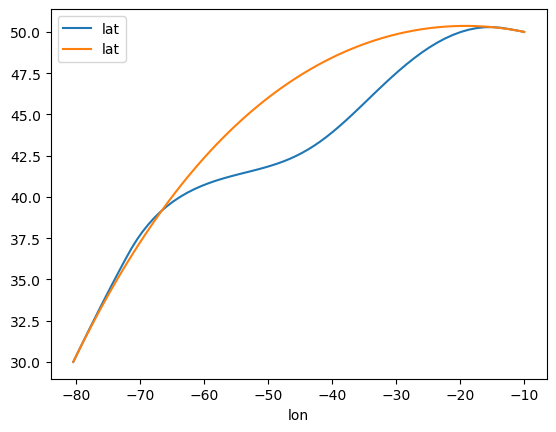

In [29]:
ax = population[imin].route.data_frame.plot.line(
    x="lon", y="lat",
)
route_0.data_frame.plot.line(
    x="lon", y="lat",
    ax=ax,
)

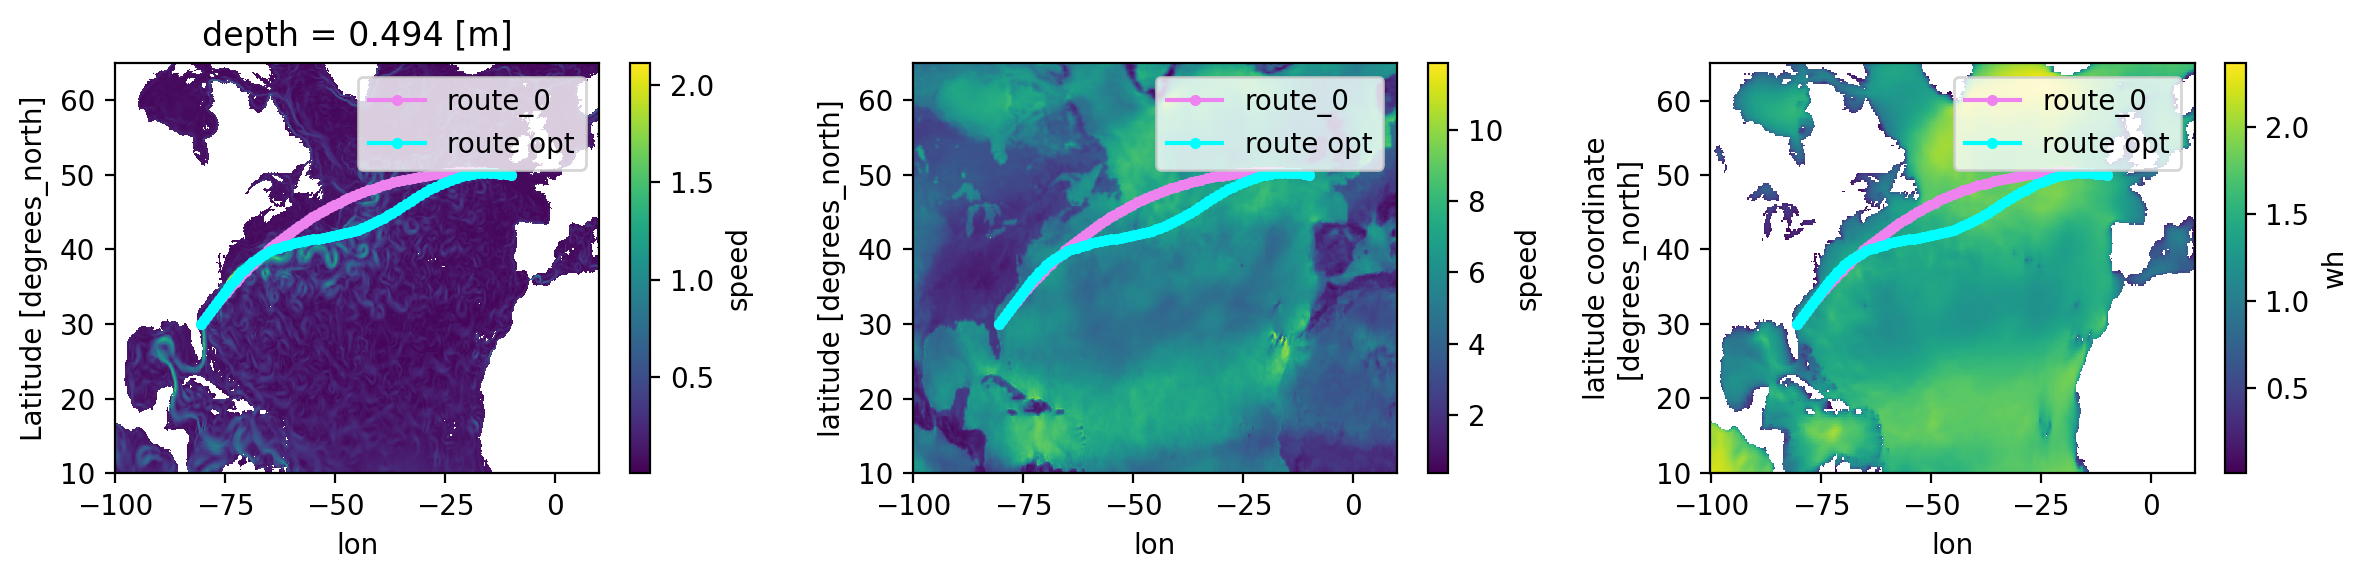

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

_currents.speed.mean("time").plot(ax=ax[0])
_winds.speed.mean("time").plot(ax=ax[1])
_waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )
for _ax in ax.flatten():
    population[imin].route.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="cyan", label="route opt"
    )
    

fig.tight_layout();

In [31]:
print(time.time() - tic, "seconds")

123.98119187355042 seconds
